In [37]:
import os
from PIL import Image
import numpy as np
import pickle

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm.notebook import tqdm

from keras import backend as k
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense,Flatten,Conv2D,MaxPooling2D,AveragePooling2D,Dropout,BatchNormalization,Activation
from keras.activations import relu,softmax
from keras.initializers import he_normal,glorot_normal,random_normal,glorot_uniform
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta,Adam
from keras.utils import np_utils

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

*Preprocessing*



In [3]:
from google.colab import drive
drive.flush_and_unmount()

Drive not mounted, so nothing to flush and unmount.


In [18]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [47]:
labels = {'Amphibia':0,'Animalia':1 ,'Arachnida':2 ,'Aves':3 , 'Fungi':4 ,'Insecta':5 ,'Mammalia':6 , 'Mollusca':7,
          'Plantae':8 , 'Reptilia':9}

In [4]:
#take a list of PIL images..
def plot_images(X ,Y):
  plt.figure(figsize=(16,7)) 

  indices = [Y.index(ele) for ele in set(Y)]
  Y_sample = [Y[i] for i in indices]
  X_sample = [X[i] for i in indices]

  for i in range(len(indices)):
    plt.subplot(2,5,i+1).set_title(Y_sample[i])
    #im = mpimg.imread(X_sample[i])
    plt.imshow(X_sample[i])
    plt.axis('off')
  
  plt.suptitle("Sample Images From the Train Dataset")
  plt.show()
  return


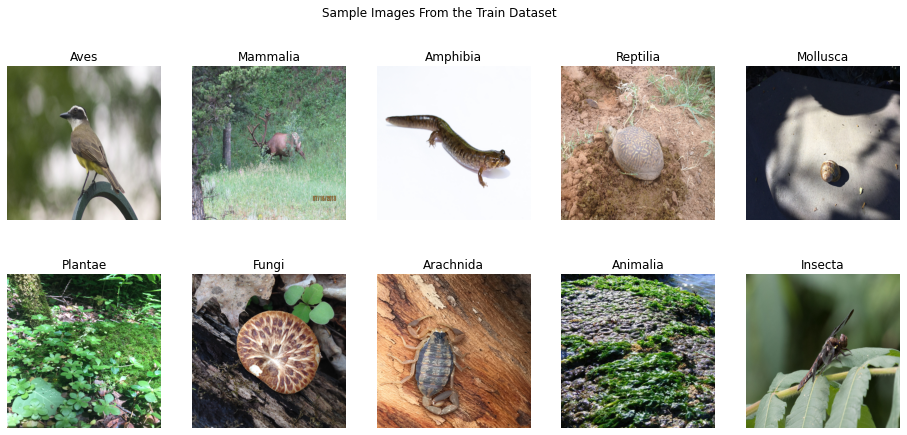

In [5]:
with open('/content/gdrive/MyDrive/Raw_data/xtrimg','rb') as f:
  X_tr_img = pickle.load(f)
with open('/content/gdrive/MyDrive/Raw_data/xtsimg','rb') as f:
  X_ts_img = pickle.load(f)
with open('/content/gdrive/MyDrive/Raw_data/ytrimg','rb') as f:
  Y_tr_img = pickle.load(f)
with open('/content/gdrive/MyDrive/Raw_data/ytsimg','rb') as f:
  Y_ts_img = pickle.load(f)

plot_images(X_tr_img , Y_tr_img)

Question 1 (5 Marks)
Build a small CNN model consisting of 5 convolution layers. Each convolution layer would be followed by a ReLU activation and a max pooling layer. Here is sample code for building one such conv-relu-maxpool block in keras.

model = Sequential()
model.add(Conv2D(16, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
After 5 such conv-relu-maxpool blocks of layers you should have one dense layer followed by the output layer containing 10 neurons (1 for each of the 10 classes). The input layer should be compatible with the images in the iNaturalist dataset.

The code should be flexible such that the number of filters, size of filters and activation function in each layer can be changed. You should also be able to change the number of neurons in the dense layer. 

In [38]:
class CNN_M:

  def __init__(self,input_shape,target_size ,num_filters,filter_size,fo,num_neurons,data_aug,dropout,BN,num_outputs):
    self.model = Sequential()
    self.input_shape = input_shape
    self.target_size = target_size
    self.num_filters = num_filters
    self.filter_size = filter_size
    self.fo = fo
    self.num_neurons =num_neurons
    self.data_aug = data_aug
    self.dropout = dropout
    self.BN = BN
    self.num_outputs = num_outputs

  def BUILD_MODEL(self):
    
    #Build 1st layer...
    self.model.add(Conv2D(filters = self.num_filters ,kernel_size =self.filter_size,use_bias = True,
                          input_shape=self.input_shape))
    self.model.add(Activation('relu'))
    self.model.add(MaxPooling2D(pool_size=(2,2)))

    cf = self.num_filters 
    for i in range(1,5):
      cf*=self.fo
      self.model.add(Conv2D(filters = cf , kernel_size = self.filter_size ,use_bias= True))
      if self.BN == 'Yes':
        self.model.add(BatchNormalization(axis = -1))

      self.model.add(Activation('relu'))
      self.model.add(Dropout(self.dropout))
      self.model.add(MaxPooling2D(pool_size=(2,2)))

    self.model.add(Flatten())
    self.model.add(Dense(units=self.num_neurons))
    
    if self.BN == 'Yes':
      self.model.add(BatchNormalization(axis = -1))
    
    self.model.add(Activation('relu'))
    self.model.add(Dropout(self.dropout))

    self.model.add(Dense(units = self.num_outputs ,activation='softmax'))

    self.model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
    return 


  #Fit model using the train datagenerator and returns fitted model..
  def fit_CNN(self , train_path ,epochs ,batch_size):

    if self.data_aug == 1:
      tr_datagen = ImageDataGenerator(rescale=1./255,validation_split = 0.1,
                                      zoom_range=0.2 ,horizontal_flip=True ,rotation_range=30 ,shear_range=12)
    else:
      tr_datagen = ImageDataGenerator(rescale=1./255,
                             validation_split = 0.1)
    
    tr_gen = tr_datagen.flow_from_directory(
        directory = train_path,target_size = self.target_size,color_mode = 'rgb',       
        batch_size = batch_size,
        class_mode = 'categorical',
        shuffle = True,
        seed = 10,
        subset = 'training'
        )

    val_gen = tr_datagen.flow_from_directory(
        directory = train_path,target_size = self.target_size,color_mode = 'rgb',
        batch_size = batch_size,
        class_mode = 'categorical',
        shuffle = True,
        seed = 10,
        subset = 'validation'
        ) 
      
    #Fitting The model...
    step_size_train = tr_gen.n//tr_gen.batch_size
    step_size_valid = val_gen.n//val_gen.batch_size

    self.model.fit_generator(generator = tr_gen,
                             steps_per_epoch = step_size_train,
                             validation_data = val_gen,
                             validation_steps = step_size_valid,
                             epochs = epochs, verbose=1)
    


    return 

  #Return the accuracy and predictions on test data ..
  def Predict_Test(self,test_path):

    ts_datagen = ImageDataGenerator(rescale = 1./255)
    test_gen = ts_datagen.flow_from_directory(
        directory = test_path,
        target_size = self.target_size,
        color_mode = 'rgb',
        batch_size = 1,
        class_mode = None,
        shuffle = False,
        seed=10
        )
    
    step_size_test = test_gen.n//test_gen.batch_size
    test_gen.reset()

    print('Getting loss,accuracy for test data..')
    metrics = self.model.evaluate_generator(generator = test_gen,
                                             steps = step_size_test,verbose=1,
                                            )
    
    print('Getting predictions for test data..')
    pred = self.model.predict_generator(generator = test_gen,
                                  steps = step_size_test,
                                  verbose = 1
                                  )
    
    
    return (metrics,pred)


**Get The Test accuracy and TestLoss  using generator**

In [39]:
!pip install wandb -qqq
import wandb
wandb.login()

True

In [40]:
sweep_config = {
  'name': 'A2.QA',
  'method': 'bayes',
  'metric': {
      'name': 'accuracy',
      'goal': 'maximize'   
    },
  'parameters': {
        'num_filters': {
            'values': [32,64]
        },
        'fo':{
            'values':[0.5,1,2]
        },
        'data_aug':{
            'values':[0,1]
        },
        'dropout':{
            'values':[0.2,0.3]
        },
        'BN':{
            'values':['Yes','No']
        }

    }
}

sweep_id = wandb.sweep(sweep_config, project='A2.QA', entity='abhisheknegi_cs20m008')

Create sweep with ID: lqp3sqt2
Sweep URL: https://wandb.ai/abhisheknegi_cs20m008/A2.QA/sweeps/lqp3sqt2


In [42]:
def train():
  run = wandb.init()
  configuration=run.config

  #target size of image..
  tsize = 256
  target_size = (tsize,tsize)
  if k.image_data_format()=='channels_first':
    input_shape = (3,tsize,tsize)

  else:
    input_shape = (tsize,tsize,3)

  ##>>>>> WORK ON A SUBSET OF DATA <<<<<<#
  train_path = '/content/gdrive/MyDrive/inaturalist_12K/train'
  test_path =  '/content/gdrive/MyDrive/inaturalist_12K/val'

  epochs =10
  batch_size =32
  cnn = CNN_M(input_shape = input_shape,
            target_size = target_size,
            num_filters = configuration.num_filters,
            filter_size =3,
            fo = configuration.fo,
            num_neurons = 64,
            data_aug = configuration.data_aug,
            dropout = configuration.dropout,
            BN = configuration.BN,
            num_outputs = 10)
  
  cnn.BUILD_MODEL()

  cnn.fit_CNN(train_path,epochs=epochs,batch_size=batch_size)
  train_acc = cnn.model.history.history['accuracy'] 
  val_acc = cnn.model.history.history['val_accuracy']

  ##>>>>> SAVE PLOT TO WAND B <<<<<<<#
  plt.figure(figsize=(6,4))
  plt.plot(np.arange(1,epochs+1),train_acc,label='train')
  plt.plot(np.arange(1,epochs+1),val_acc,label='val')
  plt.title('accuracy vs epochs')
  plt.legend()
  plt.show()
  wandb.log({"error plots":plt })

  metrics , pred = cnn.Predict_Test(test_path)  
  wandb.log({"Test Loss": metrics[0]})
  wandb.log({"Test accuracy": metrics[1]})

#train()
wandb.agent(sweep_id=sweep_id, function=train)

wandb: Agent Starting Run: avdta355 with config:
wandb: 	BN: No
wandb: 	data_aug: 1
wandb: 	dropout: 0.3
wandb: 	fo: 1
wandb: 	num_filters: 64


Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Epoch 1/10
281/281 [==============================] - 3294s 12s/step - loss: 2.3163 - accuracy: 0.1019 - val_loss: 2.2998 - val_accuracy: 0.1200
Epoch 2/10
 30/281 [==>...........................] - ETA: 29:04 - loss: 2.2993 - accuracy: 0.1333

wandb: Ctrl + C detected. Stopping sweep.
